In [2]:
from diffusion_gaussian_mixture_utils import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
weights = torch.tensor([0.3, 0.7])
data_means = torch.tensor([[-1.0, -1.0], [1.0, 1.0]])
data_covs = torch.tensor([[[1.0, 0.9], [0.9, 1.0]], [[1.0, -0.6], [-0.6, 1.0]]])

# Define the likelihood p(y|x₀)
cov_y = make_positive_semidefinite(torch.tensor([[0.5, 0.0], [0.0, 0.5]]))

y = torch.tensor([-0.7, 0.4])

In [4]:
min_sigma = 0.0
max_sigma = 10.0

schedule = lambda t: linear_sigma(t, min_sigma, max_sigma)
schedule_derivative = lambda t: linear_sigma_derivative(t, min_sigma, max_sigma)
score_function = lambda x, t: gaussian_mixture_log_gradient(x, weights, data_means, data_covs, schedule(t))

rho = 2.0
num_steps = 100
n_samples = 10000
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
prior_samples = torch.randn(n_samples, 2) * max_sigma
prior_samples[0,:] = torch.tensor([4., -4.])

samples, sample_trajectories, ts = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)

In [5]:
min_sigma = 0.0
max_sigma = 20.0

schedule = lambda t: linear_sigma(t, min_sigma, max_sigma)
schedule_derivative = lambda t: linear_sigma_derivative(t, min_sigma, max_sigma)
score_function = lambda x, t: gaussian_mixture_log_gradient_conditional(x, y, weights, data_means, data_covs, schedule(t), cov_y)

rho = 2.0
num_steps = 100
n_samples = 10000
samples_conditional, sample_trajectories_conditional, ts_conditional = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)

/u/38/rissans2/unix/Work/edm2/notebooks/diffusion_gaussian_mixture_utils.py:619: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  observation_precision @ y.T.unsqueeze(-1) +


In [6]:
def sample_ode_with_second_order_bfgs_updates(prior_samples, schedule, schedule_derivative, score_function, num_steps, init_denoiser_cov, y, device, 
                                              weights, data_means, data_covs, cov_y,
                                              rho=1.0,get_sample_paths=False):
    denoiser_covs = [init_denoiser_cov[None,:,:].repeat(prior_samples.shape[0], 1, 1)]
    inv_denoiser_covs = [torch.inverse(denoiser_covs[0])]
    d = prior_samples.shape[1]
    hessians = [(denoiser_covs[0]/schedule(1)**2 - torch.eye(d)[None,:,:])/schedule(1)**2]
    inv_hessians = [torch.inverse(hessians[0])]
    
    ts = torch.linspace(1, 0, num_steps + 1, device=device)**rho
    dts = ts[:-1] - ts[1:]
    # Reverse ODE step
    x = prior_samples#torch.randn(n_samples, d, dtype=torch.float, device=device) * schedule(1)
    y = torch.tensor(y, dtype=torch.float32, device=device)
    
    score_evals = [score_function(x, ts[0]).detach()]
    grad_log_p_y_xt = compute_gradient(x, y, weights, data_means, data_covs, schedule(ts[0]), cov_y, denoiser_covs[0])
    score_for_update = score_evals[-1] + grad_log_p_y_xt
    
    xs = [x]
    for i,t in enumerate(ts[:-1]):
        score_eval = score_evals[-1]
        xnew = reverse_ode_step_euler(x, t, dts[i], score_for_update, schedule, schedule_derivative)
        dx = xnew - x
        dt = dts[i]
        score_eval_at_xnext_tnext = score_function(xnew, t-dt)
        score_evals.append(score_eval_at_xnext_tnext.detach())
        
        denoiser_mean = x + schedule(t)**2 * score_eval
        denoiser_mean_at_xnext_tnext = xnew + schedule(t-dt)**2 * score_eval_at_xnext_tnext
        
        # Update covariances etc. in dt
        denoiser_cov_at_tnext, inv_denoiser_cov_at_tnext, hessian_at_tnext, inv_hessian_at_tnext, score_eval_at_tnext, denoiser_mean_at_tnext = update_covariance(x,
                                                        denoiser_covs[-1], inv_denoiser_covs[-1], hessians[-1], inv_hessians[-1], score_eval, denoiser_mean, schedule, t, t-dt)
        
        
        denoiser_mean_at_tnext = x + schedule(t-dt)**2 * score_function(x, t-dt)
        
        new_denoiser_cov, new_inv_denoiser_cov, new_hessian, new_inv_hessian = update_bfgs(denoiser_cov_at_tnext, inv_denoiser_cov_at_tnext, hessian_at_tnext, inv_hessian_at_tnext, score_eval_at_tnext, score_eval_at_xnext_tnext, denoiser_mean_at_tnext, denoiser_mean_at_xnext_tnext, schedule, t-dt, x, dx)
        # new_denoiser_cov, new_inv_denoiser_cov, new_hessian, new_inv_hessian = denoiser_cov_at_tnext, inv_denoiser_cov_at_tnext, hessian_at_tnext, inv_hessian_at_tnext
                
        denoiser_covs.append(new_denoiser_cov.detach())
        inv_denoiser_covs.append(new_inv_denoiser_cov.detach())
        hessians.append(new_hessian.detach())
        inv_hessians.append(new_inv_hessian.detach())
        
        grad_log_p_y_xt = compute_gradient(xnew, y, weights, data_means, data_covs, schedule(t-dt), cov_y, denoiser_covs[-1])
        score_for_update = score_evals[-1] + grad_log_p_y_xt
        
        # Append to sample path
        x = xnew
        if get_sample_paths:
            xs.append(xnew)
    if get_sample_paths:
        xs = torch.cat([x[:,None,:] for x in xs], dim=1)
        return x, xs, ts, denoiser_covs, inv_denoiser_covs, hessians, inv_hessians
    else:
        return x

max_sigma = 15.0
min_sigma = 0.001

schedule = lambda t: linear_sigma(t, min_sigma, max_sigma)
schedule_derivative = lambda t: linear_sigma_derivative(t, min_sigma, max_sigma)

torch.manual_seed(0)
np.random.seed(0)

rho = 2.0
num_steps = 100
n_samples = 10000

score_function = lambda x, t: gaussian_mixture_log_gradient_conditional(x, y, weights, data_means, data_covs, schedule(t), cov_y)
samples_correct, sample_trajectories_correct, ts = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)

def covariance_function_better(t):
    # This converges to unit variance as t -> inf, and to the correct variance as t -> 0
    # var = 1 - (-1 + np.sqrt(1+4*schedule(t)**2))/(2*schedule(t)**2)
    var = schedule(t)**2 / (1 + schedule(t)**2)
    return var * torch.eye(2)

score_function = lambda x, t: gaussian_mixture_log_gradient(x, weights, data_means, data_covs, schedule(t)) \
                                + compute_gradient(x, torch.tensor(y, dtype=torch.float32), weights, data_means, data_covs, schedule(t), cov_y, covariance_function_better(t))
samples_diagonal, sample_trajectories_diagonal, ts = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)
sample_trajectories_diagonal = sample_trajectories_diagonal.detach()
samples_diagonal = samples_diagonal.detach()

init_denoiser_cov = gaussian_mixture_covariance(weights, data_means, data_covs)
score_function = lambda x, t: gaussian_mixture_log_gradient(x, weights, data_means, data_covs, schedule(t))
samples_bfgs, sample_trajectories_bfgs, ts, denoiser_covs, inv_denoiser_covs, hessians, inv_hessians = sample_ode_with_second_order_bfgs_updates(prior_samples, schedule, schedule_derivative, score_function, num_steps, init_denoiser_cov, y, 'cpu', 
                                              weights, data_means, data_covs, cov_y,
                                              rho=rho,get_sample_paths=True)
samples_bfgs = samples_bfgs.detach()
sample_trajectories_bfgs = sample_trajectories_bfgs.detach()


/tmp/ipykernel_89534/2047997598.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  + compute_gradient(x, torch.tensor(y, dtype=torch.float32), weights, data_means, data_covs, schedule(t), cov_y, covariance_function_better(t))
/u/38/rissans2/unix/Work/edm2/notebooks/diffusion_gaussian_mixture_utils.py:817: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights)
/u/38/rissans2/unix/Work/edm2/notebooks/diffusion_gaussian_mixture_utils.py:818: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(means)
/u

In [7]:
from scipy.stats import gaussian_kde
# Create a kernel density estimate
kde = gaussian_kde(samples_conditional.T)
kde_diagonal = gaussian_kde(samples_diagonal.T)
kde_bfgs = gaussian_kde(samples_bfgs.T)
# Create a grid of points
lims = (-4,4,-4,4)
x_grid, y_grid = np.meshgrid(np.linspace(lims[0], lims[1], 100), np.linspace(lims[2], lims[3], 100))
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
# Evaluate the KDE on the grid
Z = kde(positions)
Z = Z.reshape(x_grid.shape)
Z_diagonal = kde_diagonal(positions)
Z_diagonal = Z_diagonal.reshape(x_grid.shape)
Z_bfgs = kde_bfgs(positions)
Z_bfgs = Z_bfgs.reshape(x_grid.shape)

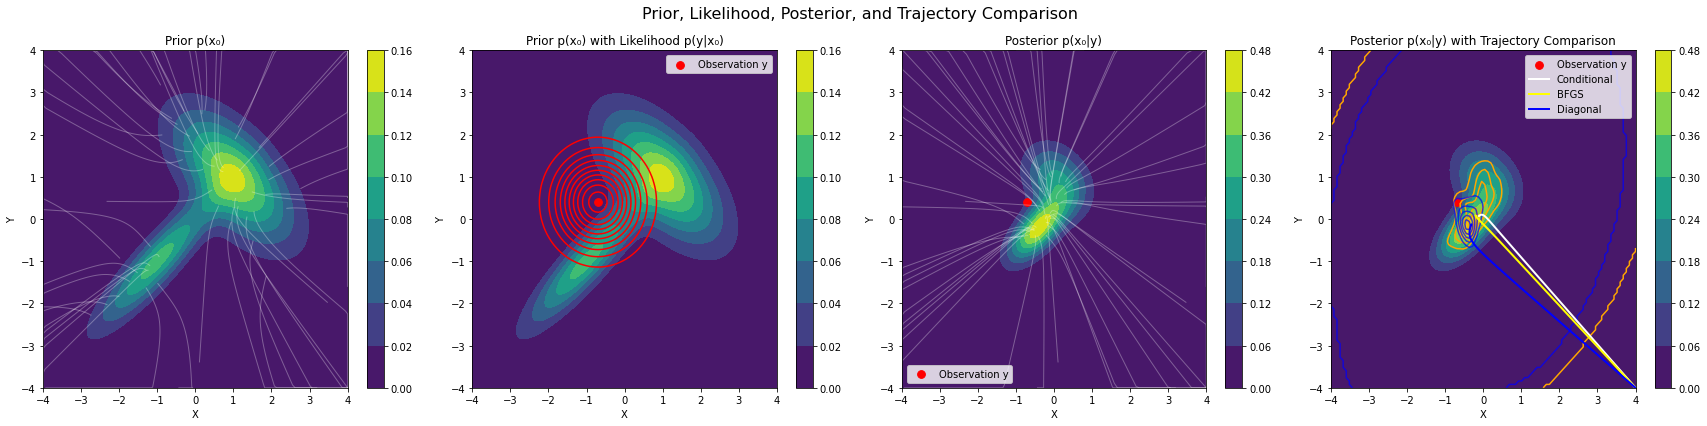

In [8]:
# Define p(x_t|x₀) for the plot
cov_xt = make_positive_semidefinite(torch.tensor([[1.0, 0.0], [0.0, 1.0]]))

# Create grid for plotting
X, Y, pos = create_grid((-4, 4), (-4, 4))

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Prior, Likelihood, Posterior, and Trajectory Comparison', fontsize=16)

# Set the number of contour levels
num_contour_levels = 8

# Plot prior p(x₀)
Z_prior = gaussian_mixture(pos, weights, data_means, data_covs)
contourf = axs[0].contourf(X, Y, Z_prior.reshape(X.shape), levels=num_contour_levels, cmap='viridis')
axs[0].set_title('Prior p(x₀)')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(contourf, ax=axs[0])

# Plot sample trajectories
num_trajectories_to_plot = 50  # Adjust this number as needed
for i in range(num_trajectories_to_plot):
    trajectory = sample_trajectories[i]
    # Clip the trajectory to the plot range
    trajectory_x = np.clip(trajectory[:, 0], -4, 4)
    trajectory_y = np.clip(trajectory[:, 1], -4, 4)
    axs[0].plot(trajectory_x, trajectory_y, color='white', alpha=0.3, linewidth=1.0)

axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)

# Plot prior p(x₀) with likelihood p(y|x₀) as contour
contourf = axs[1].contourf(X, Y, Z_prior.reshape(X.shape), levels=num_contour_levels, cmap='viridis')
mvn_y = MultivariateNormal(y, cov_y)
Z_likelihood = torch.exp(mvn_y.log_prob(pos))
contour = axs[1].contour(X, Y, Z_likelihood.reshape(X.shape), levels=10, colors='red')
axs[1].set_title('Prior p(x₀) with Likelihood p(y|x₀)')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].scatter(y[0], y[1], color='red', s=60, label='Observation y')
axs[1].legend()
fig.colorbar(contourf, ax=axs[1])

# Calculate and plot posterior p(x₀|y)
new_weights, new_means, new_covs = calculate_posterior(y, weights, data_means, data_covs, cov_y)
Z_posterior = gaussian_mixture(pos, new_weights, new_means, new_covs)
contourf = axs[2].contourf(X, Y, Z_posterior.reshape(X.shape), levels=num_contour_levels, cmap='viridis')
axs[2].set_title('Posterior p(x₀|y)')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].scatter(y[0], y[1], color='red', s=60, label='Observation y')

# Plot conditional sample trajectories
num_trajectories_to_plot = 50  # Adjust this number as needed
for i in range(num_trajectories_to_plot):
    trajectory = sample_trajectories_conditional[i]
    # Clip the trajectory to the plot range
    trajectory_x = np.clip(trajectory[:, 0], -4, 4)
    trajectory_y = np.clip(trajectory[:, 1], -4, 4)
    axs[2].plot(trajectory_x, trajectory_y, color='white', alpha=0.3, linewidth=1.0)

axs[2].set_xlim(-4, 4)
axs[2].set_ylim(-4, 4)
axs[2].legend()
fig.colorbar(contourf, ax=axs[2])

# New plot: Posterior with single trajectory comparison and BFGS contour
contourf = axs[3].contourf(X, Y, Z_posterior.reshape(X.shape), levels=num_contour_levels, cmap='viridis')
axs[3].set_title('Posterior p(x₀|y) with Trajectory Comparison')
axs[3].set_xlabel('X')
axs[3].set_ylabel('Y')
axs[3].scatter(y[0], y[1], color='red', s=60, label='Observation y')

# Overlay BFGS contour plot with fewer levels
contour_bfgs = axs[3].contour(x_grid, y_grid, Z_bfgs, levels=5, colors='orange', alpha=1.0)

# Overlay diagonal contour plot with fewer levels
contour_diagonal = axs[3].contour(x_grid, y_grid, Z_diagonal, levels=5, colors='blue', alpha=0.7)

# Plot single trajectory for both conditional and BFGS
trajectory_index = 0  # You can change this index if needed
trajectory_conditional = sample_trajectories_conditional[trajectory_index]
trajectory_bfgs = sample_trajectories_bfgs[trajectory_index]
trajectory_diagonal = sample_trajectories_diagonal[trajectory_index]

# Clip the trajectories to the plot range
trajectory_conditional_x = np.clip(trajectory_conditional[:, 0], -4, 4)
trajectory_conditional_y = np.clip(trajectory_conditional[:, 1], -4, 4)
trajectory_bfgs_x = np.clip(trajectory_bfgs[:, 0], -4, 4)
trajectory_bfgs_y = np.clip(trajectory_bfgs[:, 1], -4, 4)
trajectory_diagonal_x = np.clip(trajectory_diagonal[:, 0], -4, 4)
trajectory_diagonal_y = np.clip(trajectory_diagonal[:, 1], -4, 4)

axs[3].plot(trajectory_conditional_x, trajectory_conditional_y, color='white', linewidth=2.0, label='Conditional')
axs[3].plot(trajectory_bfgs_x, trajectory_bfgs_y, color='yellow', linewidth=2.0, label='BFGS')
axs[3].plot(trajectory_diagonal_x, trajectory_diagonal_y, color='blue', linewidth=2.0, label='Diagonal')

axs[3].set_xlim(-4, 4)
axs[3].set_ylim(-4, 4)
axs[3].legend()
fig.colorbar(contourf, ax=axs[3])

plt.tight_layout()
plt.show()

In [9]:
import matplotlib.image as mpimg

def bitmappify(ax, dpi=None):
    """
    Convert vector axes content to raster (bitmap) images
    """
    fig = ax.figure
    # safe plot without axes
    ax.set_axis_off()
    fig.savefig('temp.png', dpi=dpi, transparent=True)
    ax.set_axis_on()

    # remember geometry
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    xb = ax.bbox._bbox.corners()[:,0]
    xb = (min(xb), max(xb))
    yb = ax.bbox._bbox.corners()[:,1]
    yb = (min(yb), max(yb))

    # compute coordinates to place bitmap image later
    xb = (- xb[0] / (xb[1] - xb[0]),
        (1 - xb[0]) / (xb[1] - xb[0]))
    xb = (xb[0] * (xl[1] - xl[0]) + xl[0],
        xb[1] * (xl[1] - xl[0]) + xl[0])
    yb = (- yb[0] / (yb[1] - yb[0]),
        (1 - yb[0]) / (yb[1] - yb[0]))
    yb = (yb[0] * (yl[1] - yl[0]) + yl[0],
        yb[1] * (yl[1] - yl[0]) + yl[0])

    # replace the dots by the bitmap
    ax.clear()  # This clears all artists including collections and lines
    img = mpimg.imread('temp.png')
    ax.imshow(img, origin='upper',
             aspect='auto', extent=(xb[0], xb[1], yb[0], yb[1]), label='_nolegend_')

    # reset view
    ax.set_xlim(xl)
    ax.set_ylim(yl)

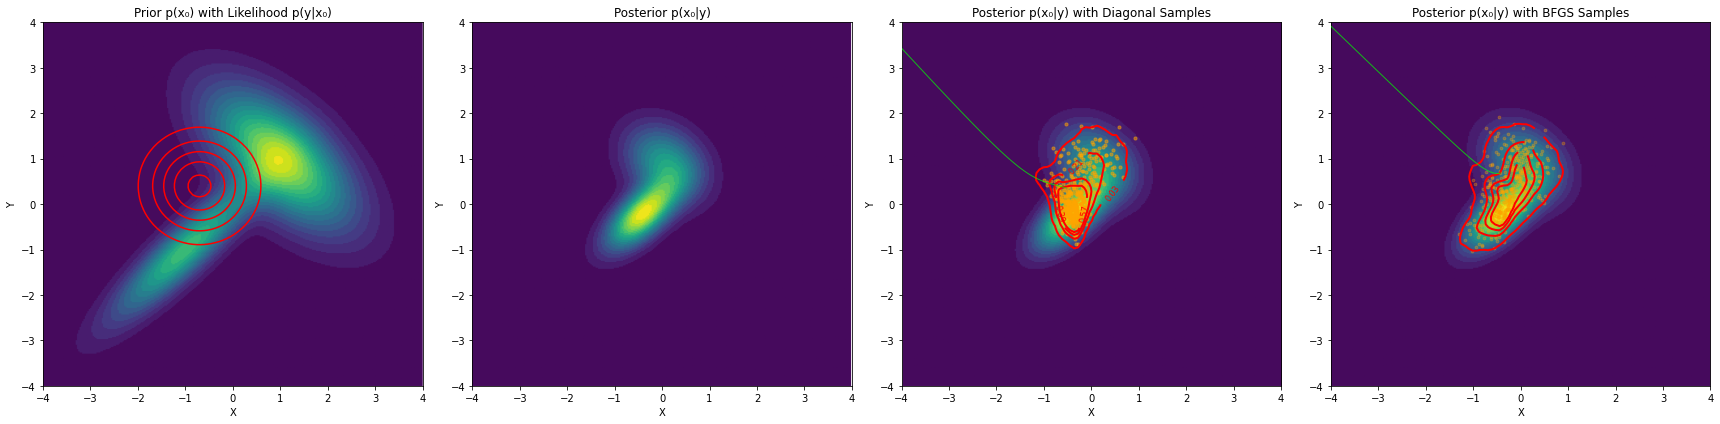

In [10]:
import tikzplotlib

# Define p(x_t|x₀) for the plot
cov_xt = make_positive_semidefinite(torch.tensor([[1.0, 0.0], [0.0, 1.0]]))

# Create grid for plotting
X, Y, pos = create_grid((-4, 4), (-4, 4))

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Plot prior p(x₀) with likelihood p(y|x₀) as contour
contourf = axs[0].contourf(X, Y, Z_prior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(axs[0])
mvn_y = MultivariateNormal(y, cov_y)
Z_likelihood = torch.exp(mvn_y.log_prob(pos))
# Create a constant red color contour
contour = axs[0].contour(X, Y, Z_likelihood.reshape(X.shape), levels=5, colors='red')
axs[0].set_title('Prior p(x₀) with Likelihood p(y|x₀)')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
# axs[0].legend()

# Calculate and plot posterior p(x₀|y)
new_weights, new_means, new_covs = calculate_posterior(y, weights, data_means, data_covs, cov_y)
Z_posterior = gaussian_mixture(pos, new_weights, new_means, new_covs)
contourf = axs[1].contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(axs[1])
axs[1].set_title('Posterior p(x₀|y)')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

# New plot: Posterior with diagonal samples
contourf = axs[2].contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(axs[2])
axs[2].set_title('Posterior p(x₀|y) with Diagonal Samples')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')

# Plot diagonal samples, limited to the first N=300
N = 500
axs[2].scatter(samples_diagonal[:N, 0], samples_diagonal[:N, 1], color='orange', alpha=0.5, s=10, label='Diagonal Samples')

# Plot Z_diagonal as a contour plot on top
# Z_diag_reshaped = Z_diag.reshape(X.shape)
levels = np.linspace(Z_posterior.min()+0.03, Z_posterior.max()+0.1, 4)
contour_diag = axs[2].contour(x_grid, y_grid, Z_diagonal, levels=levels, colors='red', linewidths=2)
axs[2].clabel(contour_diag, inline=True, fontsize=8, fmt='%.2f')

# Plot trajectory of one sample
sample_index = 7  # Choose the first sample for demonstration
trajectory = sample_trajectories_diagonal[sample_index]
# Plot the trajectory
ax_traj = axs[2].plot(trajectory[:, 0], trajectory[:, 1], color='lime', linewidth=1, alpha=0.7, zorder=10)

axs[2].set_xlim(-4, 4)
axs[2].set_ylim(-4, 4)
# axs[2].legend()
# New plot: Posterior with BFGS samples

levels = np.linspace(Z_posterior.min(), Z_posterior.max(), 20)
contourf = axs[3].contourf(X, Y, Z_posterior.reshape(X.shape), levels=levels, cmap='viridis')
bitmappify(axs[3])
axs[3].set_title('Posterior p(x₀|y) with BFGS Samples')
axs[3].set_xlabel('X')
axs[3].set_ylabel('Y')

# Plot BFGS samples, limited to the first N=300
axs[3].scatter(samples_bfgs[:N, 0], samples_bfgs[:N, 1], color='orange', alpha=0.3, s=8, label='BFGS Samples')

# Plot Z_bfgs as a contour plot on top
# Z_diag_reshaped = Z_diag.reshape(X.shape)
# contour_bfgs = axs[3].contour(x_grid, y_grid, Z_bfgs, levels=4, colors='red', linewidths=2)
levels = np.linspace(Z_posterior.min()+0.03, Z_posterior.max()+0.1, 4)
contour_bfgs = axs[3].contour(x_grid, y_grid, Z_bfgs, levels=levels, colors='red', linewidths=2)
axs[3].clabel(contour_bfgs, inline=True, fontsize=8, fmt='')
# axs[3].clabel(contour_bfgs, inline=True, fontsize=8, fmt='%.2f')

# Plot trajectory of one sample
trajectory = sample_trajectories_bfgs[sample_index]

# Plot the trajectory
ax_traj = axs[3].plot(trajectory[:, 0], trajectory[:, 1], color='lime', linewidth=1, alpha=0.7, zorder=10)

axs[3].set_xlim(-4, 4)
axs[3].set_ylim(-4, 4)
# axs[3].legend()

plt.tight_layout()
# plt.show()

tikzplotlib.save('fig_2/fig_2.tex',axis_width='\\figurewidth',axis_height='\\figureheight')

In [12]:
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
num_levels_base = 5
cmap = plt.cm.get_cmap('YlGn')  # YlGn is a yellow-green colormap, which is close to lime

points_along_trajectory_to_visualise = [50, 75, 85]
for idx, point in enumerate(points_along_trajectory_to_visualise):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Get the covariance matrix for this point
    cov = denoiser_covs[point][0]
    
    # Create a grid of points for the heatmap
    tiny_x, tiny_y = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))
    tiny_pos = np.dstack((tiny_x, tiny_y))
    
    # Create the multivariate normal distribution for the heatmap
    tiny_rv = multivariate_normal(np.array([0, 0]), cov)
    
    # Plot the Gaussian distribution as a heatmap
    levels = np.linspace(tiny_rv.pdf(tiny_pos).min(), tiny_rv.pdf(tiny_pos).max(), num_levels_base + 1)
    
    # Create a custom colormap with decreased alpha values
    colors = cmap(np.linspace(0, 1, num_levels_base + 1))
    colors[:, -1] = [0] + [0.8] * num_levels_base  # Decreased alpha from 1.0 to 0.5
    custom_cmap = ListedColormap(colors)
    
    plt.contourf(tiny_x, tiny_y, tiny_rv.pdf(tiny_pos), levels=levels, cmap=custom_cmap)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Save the plot as a PNG file
    plt.savefig(f'fig/fig_2/our_gaussian_at_point_{idx+1}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Create separate plots for the Gaussian distributions based on the new denoiser covariance definition
t_to_plot = [ts[p] for p in points_along_trajectory_to_visualise]
for idx, t in enumerate(t_to_plot):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Calculate the new covariance matrix
    new_cov = (schedule(t)**2 / (1 + schedule(t)**2)) * np.eye(2)
    
    # Create a grid of points for the heatmap
    tiny_x, tiny_y = np.meshgrid(np.linspace(-2.0, 2.0, 100), np.linspace(-2.0, 2.0, 100))
    tiny_pos = np.dstack((tiny_x, tiny_y))
    
    # Create the multivariate normal distribution for the heatmap
    tiny_rv = multivariate_normal(np.array([0, 0]), new_cov)
    
    # Plot the Gaussian distribution as a heatmap
    levels = np.linspace(tiny_rv.pdf(tiny_pos).min(), tiny_rv.pdf(tiny_pos).max(), num_levels_base + 1)
    
    # Create a custom colormap with decreased alpha values
    colors = cmap(np.linspace(0, 1, num_levels_base + 1))
    colors[:, -1] = [0] + [0.8] * num_levels_base  # Decreased alpha from 1.0 to 0.5
    custom_cmap = ListedColormap(colors)
    
    plt.contourf(tiny_x, tiny_y, tiny_rv.pdf(tiny_pos), levels=levels, cmap=custom_cmap)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Save the plot as a PNG file
    plt.savefig(f'fig/fig_2/diagonal_gaussian_at_t_{idx}.png', dpi=300, bbox_inches='tight')
    plt.close()

print("New Gaussian plots with decreased alpha have been saved in the fig/fig_2/ directory.")

/tmp/ipykernel_89534/947878559.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlGn')  # YlGn is a yellow-green colormap, which is close to lime


New Gaussian plots with decreased alpha have been saved in the fig/fig_2/ directory.


In [28]:
import tikzplotlib
import os
import shutil

# Path to the fig_2 directory
fig_2_path = 'fig/fig_2/'

# Check if the directory exists
if os.path.exists(fig_2_path):
    # If it exists, delete all its contents
    for filename in os.listdir(fig_2_path):
        file_path = os.path.join(fig_2_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
    print(f"All contents of {fig_2_path} have been deleted.")
else:
    print(f"The directory {fig_2_path} does not exist.")

datapath = 'fig/fig_2/'

# Define p(x_t|x₀) for the plot
cov_xt = make_positive_semidefinite(torch.tensor([[1.0, 0.0], [0.0, 1.0]]))

# Create grid for plotting
X, Y, pos = create_grid((-4, 4), (-4, 4))

# Plot 1: Prior p(x₀) with likelihood p(y|x₀) as contour
fig, ax = plt.subplots(figsize=(8, 6))
contourf = ax.contourf(X, Y, Z_prior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(ax)
mvn_y = MultivariateNormal(y, cov_y)
Z_likelihood = torch.exp(mvn_y.log_prob(pos))
contour = ax.contour(X, Y, Z_likelihood.reshape(X.shape), levels=5, colors='red')
# ax.set_title('Prior p(x₀) with Likelihood p(y|x₀)')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
plt.tight_layout()
tikzplotlib.save(f'{datapath}fig_2_prior_likelihood.tex', axis_width='\\figurewidth', axis_height='\\figureheight')#, tex_relative_path_to_data='fig/fig_2/')
plt.close()

# Plot 2: Posterior p(x₀|y)
fig, ax = plt.subplots(figsize=(8, 6))
new_weights, new_means, new_covs = calculate_posterior(y, weights, data_means, data_covs, cov_y)
Z_posterior = gaussian_mixture(pos, new_weights, new_means, new_covs)
contourf = ax.contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(ax)
# ax.set_title('Posterior $p(\\vx_0\\mid \\vy)$')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
plt.tight_layout()
tikzplotlib.save(f'{datapath}fig_2_posterior.tex', axis_width='\\figurewidth', axis_height='\\figureheight')#, tex_relative_path_to_data='fig/fig_2/')
plt.close()

# Plot 3: Posterior with diagonal samples
fig, ax = plt.subplots(figsize=(8, 6))
contourf = ax.contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
bitmappify(ax)
# ax.set_title('Posterior p(x₀|y) with Diagonal Samples')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
N = 100
ax.plot(samples_diagonal[:N, 0], samples_diagonal[:N, 1], color='orange', alpha=0.3, markersize=1, marker='.', linestyle='None', label='Diagonal Samples')
levels = np.linspace(Z_posterior.min()+0.03, Z_posterior.max()+0.1, 4)
contour_diag = ax.contour(x_grid, y_grid, Z_diagonal, levels=levels, colors='red', linewidths=2)
# Plot trajectory of one sample
sample_index = 7  # Choose the first sample for demonstration
trajectory = sample_trajectories_diagonal[sample_index]
# Plot the trajectory
ax_traj = ax.plot(trajectory[:, 0], trajectory[:, 1], color='lime', linewidth=1, alpha=0.7, zorder=10)
ax.clabel(contour_diag, inline=True, fontsize=8, fmt='%.2f')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)m
plt.tight_layout()
tikzplotlib.save(f'{datapath}fig_2_posterior_diagonal.tex', axis_width='\\figurewidth', axis_height='\\figureheight')#, tex_relative_path_to_data='fig/fig_2/')
plt.close()

# Plot 4: Posterior with BFGS samples
fig, ax = plt.subplots(figsize=(8, 6))
levels = np.linspace(Z_posterior.min(), Z_posterior.max(), 20)
contourf = ax.contourf(X, Y, Z_posterior.reshape(X.shape), levels=levels, cmap='viridis')
bitmappify(ax)
# ax.set_title('Posterior p(x₀|y) with BFGS Samples')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
ax.plot(samples_bfgs[:N, 0], samples_bfgs[:N, 1], color='orange', alpha=0.3, markersize=1, marker='.', linestyle='None', label='BFGS Samples')
levels = np.linspace(Z_posterior.min()+0.03, Z_posterior.max()+0.1, 4)
contour_bfgs = ax.contour(x_grid, y_grid, Z_bfgs, levels=levels, colors='red', linewidths=2)
trajectory = sample_trajectories_bfgs[sample_index]
# Plot the trajectory
ax_traj = ax.plot(trajectory[:, 0], trajectory[:, 1], color='lime', linewidth=1, alpha=0.7, zorder=10)
ax.clabel(contour_bfgs, inline=True, fontsize=8, fmt='')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
# plt.legend()
plt.tight_layout()
tikzplotlib.save(f'{datapath}fig_2_posterior_bfgs.tex', axis_width='\\figurewidth', axis_height='\\figureheight')#, tex_relative_path_to_data='fig/fig_2/')
plt.close()

import re
import os

def add_path_to_png(tex_file):
    with open(tex_file, 'r') as file:
        content = file.read()
    
    # Use regex to find and modify the line
    modified_content = re.sub(
        r'(\\addplot graphics \[.*\] \{)(.*\.png\};)',
        r'\1fig/fig_2/\2',
        content
    )
    
    with open(tex_file, 'w') as file:
        file.write(modified_content)

# List of .tex files to modify
tex_files = [
    f'{datapath}fig_2_posterior.tex',
    f'{datapath}fig_2_posterior_diagonal.tex',
    f'{datapath}fig_2_posterior_bfgs.tex',
    f'{datapath}fig_2_prior_likelihood.tex'
]

# Apply the modification to each file
for tex_file in tex_files:
    if os.path.exists(tex_file):
        add_path_to_png(tex_file)
        print(f"Modified {tex_file}")
    else:
        print(f"File not found: {tex_file}")


All contents of fig/fig_2/ have been deleted.
Modified fig/fig_2/fig_2_posterior.tex
Modified fig/fig_2/fig_2_posterior_diagonal.tex
Modified fig/fig_2/fig_2_posterior_bfgs.tex
Modified fig/fig_2/fig_2_prior_likelihood.tex
